🌡️ Convirtiendo datos a Celsius para que coincidan con el YAML...


/home/legion/bulk/MAIE_tesis2026/f01_code/MAIE_tesis_github/venv/lib/python3.12/site-packages/dask/_task_spec.py:768: RuntimeWarning: invalid value encountered in cos
  return self.func(*new_argspec)
/home/legion/bulk/MAIE_tesis2026/f01_code/MAIE_tesis_github/venv/lib/python3.12/site-packages/dask/_task_spec.py:768: RuntimeWarning: invalid value encountered in sin
  return self.func(*new_argspec)


🚀 Ejecutando .show() para lst_celsius_color01...


/home/legion/bulk/MAIE_tesis2026/f01_code/MAIE_tesis_github/venv/lib/python3.12/site-packages/dask/_task_spec.py:768: RuntimeWarning: invalid value encountered in cos
  return self.func(*new_argspec)
/home/legion/bulk/MAIE_tesis2026/f01_code/MAIE_tesis_github/venv/lib/python3.12/site-packages/dask/_task_spec.py:768: RuntimeWarning: invalid value encountered in sin
  return self.func(*new_argspec)


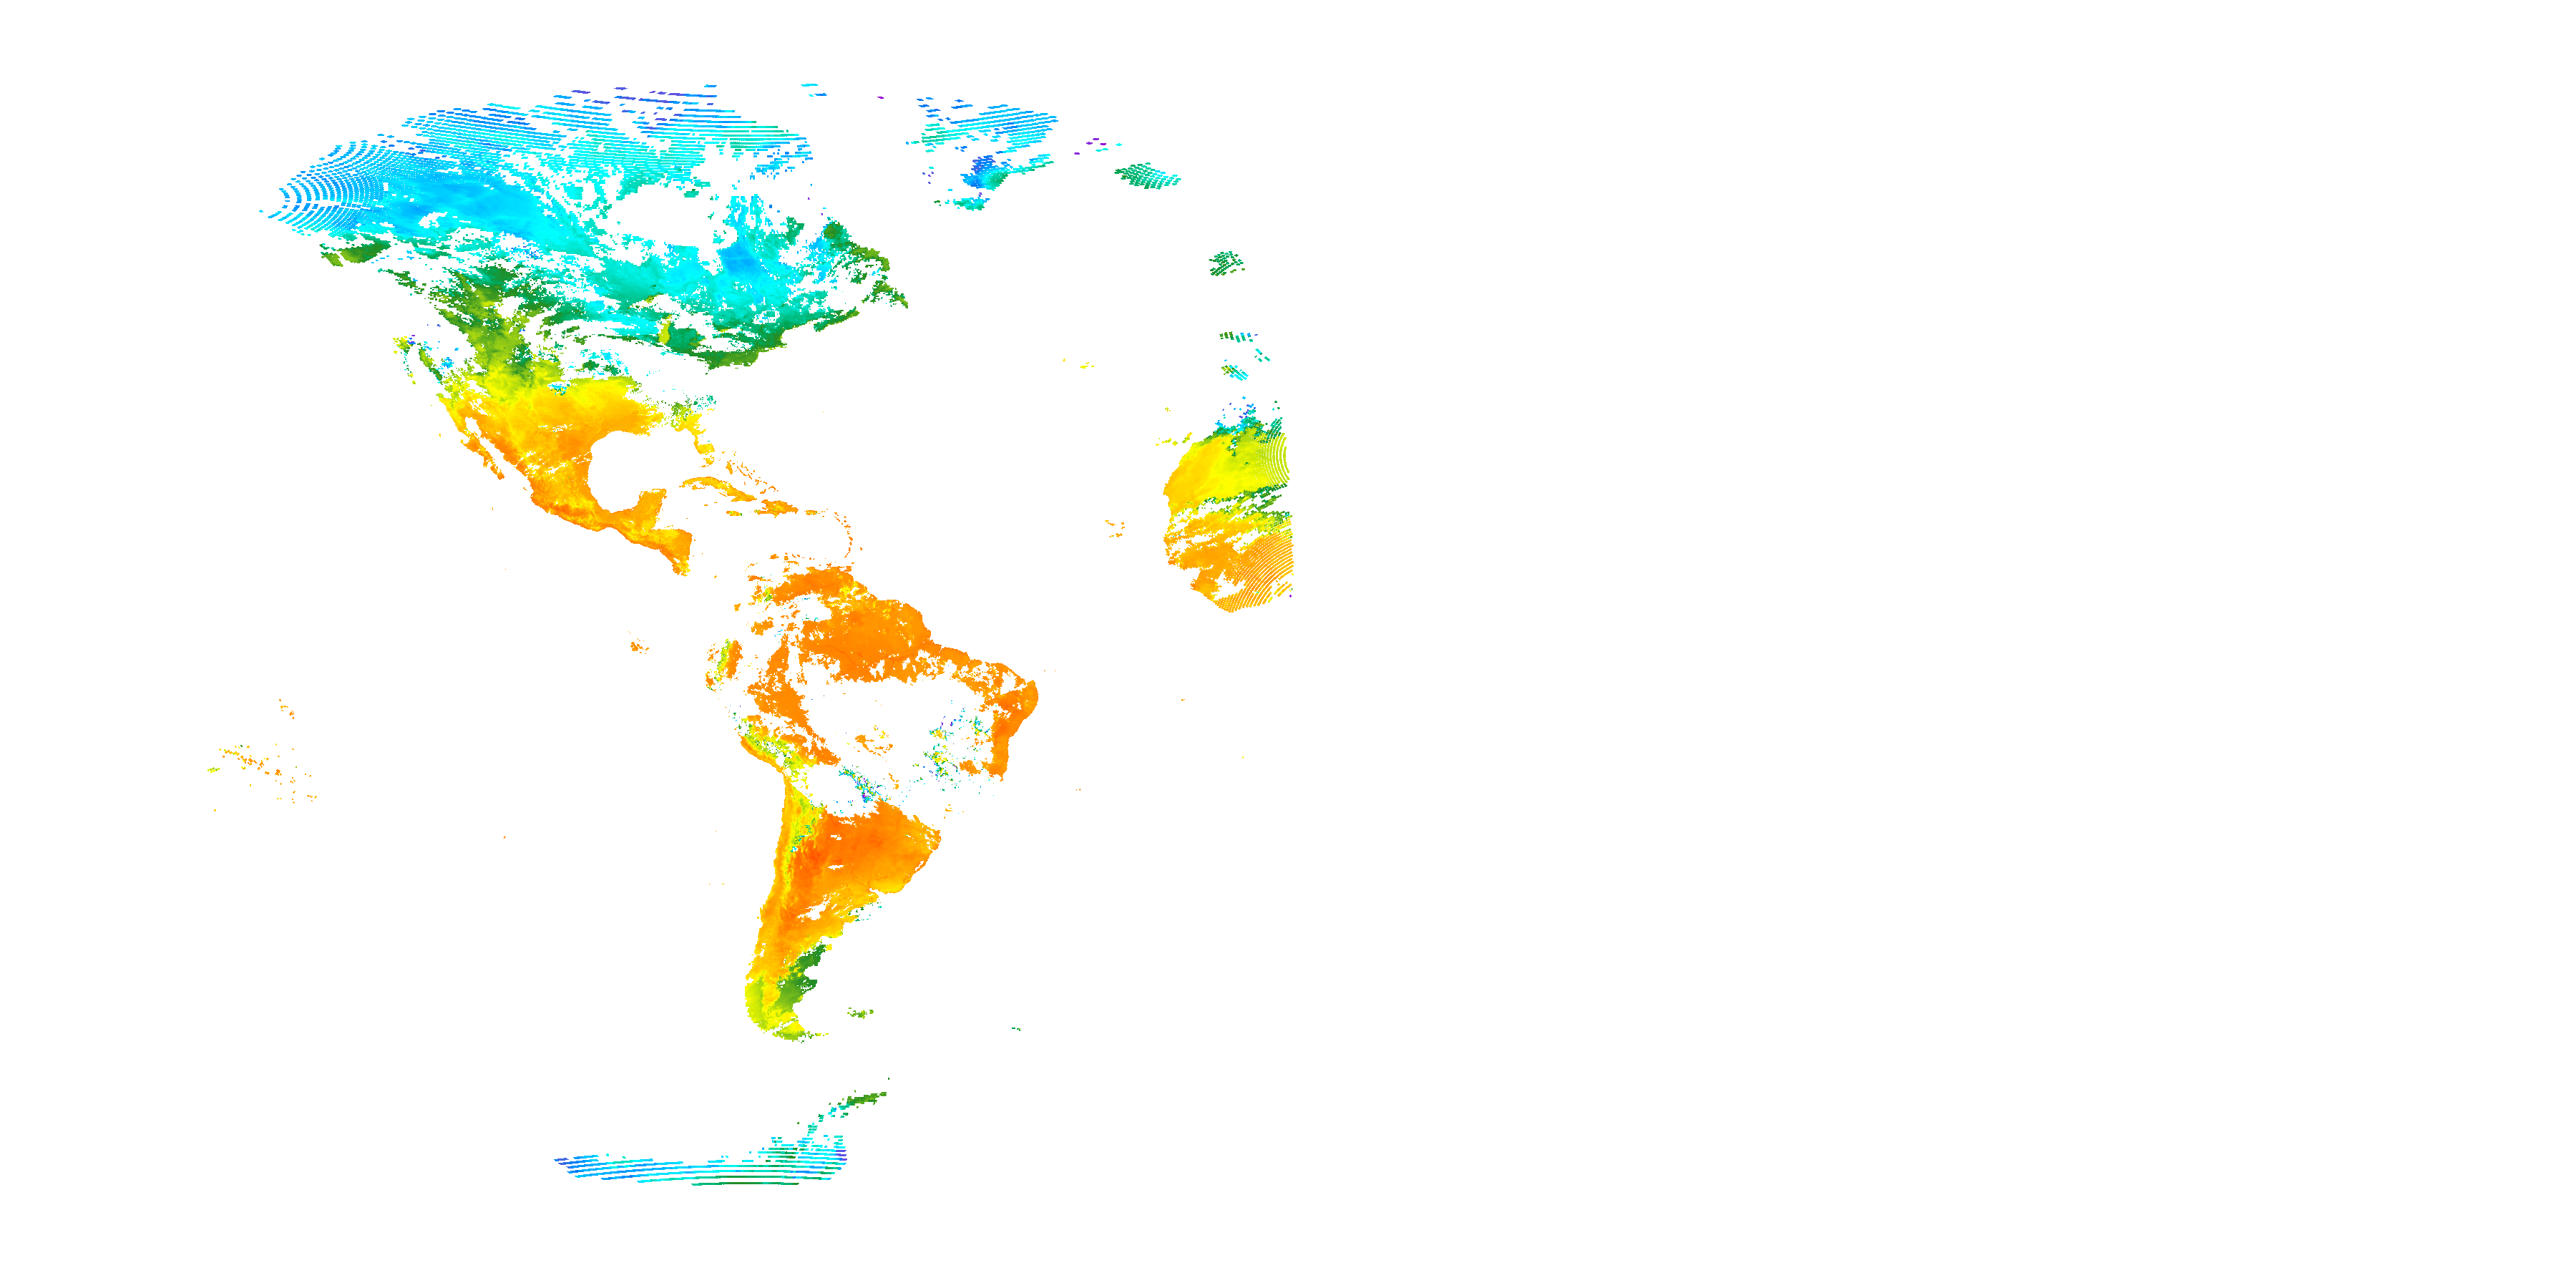

In [16]:
import sys
import os
import satpy
from pathlib import Path
from satpy import Scene
from pyresample.geometry import AreaDefinition

# 1. RUTAS
current_dir = Path(os.getcwd())
root_path = current_dir.parent.parent
sys.path.append(str(root_path / "src"))

# 2. CONFIGURACIÓN
BASE_PROCESSOR = root_path / "src" / "goes_processor"
CUSTOM_CONFIG = BASE_PROCESSOR / "satpy_config"

# Registramos tus YAMLs
satpy.config.set(config_path=[str(CUSTOM_CONFIG)] + satpy.config.get("config_path", []))

# 3. CARGA DE ESCENA
nc_files = list(current_dir.glob("*.nc"))
scn = Scene(reader="abi_l2_nc", filenames=[str(nc_files[0])])

product_color = "lst_celsius_color01"
scn.load([product_color])

# 4. REMUESTREO
area_def = AreaDefinition('wgs84', 'Global', 'epsg4326', 'EPSG:4326', 3600, 1800, [-180, -90, 180, 90])
resampled_scn = scn.resample(area_def, resampler='kd_tree')

# --- 5. CORRECCIÓN CRÍTICA PARA CELSIUS ---
# Si no hacemos esto, verás todo ROJO porque los datos están en ~300K
print("🌡️ Convirtiendo datos a Celsius para que coincidan con el YAML...")
if resampled_scn[product_color].mean() > 100:
    # Restamos para entrar en el rango -60 a 60 del enhancement
    resampled_scn[product_color] = resampled_scn[product_color] - 273.15
    # Actualizamos unidades para que Satpy no se confunda
    resampled_scn[product_color].attrs['units'] = 'Celsius'

# 6. MOSTRAR
print(f"🚀 Ejecutando .show() para {product_color}...")
resampled_scn.show(product_color)

In [2]:
import sys
import os
import glob
import satpy
from pathlib import Path
from satpy import Scene
from pyresample import AreaDefinition
import matplotlib.pyplot as plt

# 1. SETUP DE RUTAS DINÁMICO
# Asumimos que el script está en la raíz o en una carpeta 'scripts'
# Retrocedemos hasta encontrar la raíz del proyecto
current_path = Path(os.getcwd())
root_path = current_path if (current_path / "src").exists() else current_path.parent

# Añadimos 'src' al path para poder importar goes_processor
sys.path.append(str(root_path / "src"))

# 2. CONFIGURACIÓN GLOBAL DE SATPY (Igual que en tu main.py)
BASE_DIR = root_path / "src" / "goes_processor"
CUSTOM_CONFIG = BASE_DIR / "satpy_config"
CACHE_DIR = BASE_DIR / "satpy_cache"

# Registrar los paths en Satpy
current_paths = satpy.config.get("config_path", [])
if str(CUSTOM_CONFIG) not in current_paths:
    satpy.config.set(config_path=[str(CUSTOM_CONFIG)] + current_paths)

satpy.config.set(cache_dir=str(CACHE_DIR))
os.environ['PYRESAMPLE_CACHE_DIR'] = str(CACHE_DIR)

print(f"✅ Satpy Config Path: {satpy.config.get('config_path')}")
print(f"✅ Satpy Cache: {satpy.config.get('cache_dir')}")



✅ Satpy Config Path: ['/home/legion/bulk/MAIE_tesis2026/f01_code/MAIE_tesis_github/notebooks/src/goes_processor/satpy_config']
✅ Satpy Cache: /home/legion/bulk/MAIE_tesis2026/f01_code/MAIE_tesis_github/notebooks/src/goes_processor/satpy_cache


In [4]:

input_file = "OR_ABI-L2-LSTF-M6_G19_s20260030000228_e20260030009536_c20260030015142.nc"
print(f"🚀 Procesando archivo: {Path(input_file).name}")

# 4. CARGAR ESCENA Y PRODUCTOS
scn = Scene(reader="abi_l2_nc", filenames=[input_file])

# Cargamos el producto de tu tesis (Celsius + Color)
# Asegúrate de que este nombre coincida con tu enhancements/abi.yaml
product = "lst_celsius_color01" 
raw_product = "LST"

scn.load([product, raw_product])

# 5. CONVERSIÓN CIENTÍFICA (Kelvin a Celsius)
if scn[raw_product].mean() > 100:
    scn[raw_product] = scn[raw_product] - 273.15
    scn[raw_product].attrs['units'] = 'Celsius'

# 6. REPROYECCIÓN WGS84 (3600x1800)
area_def = AreaDefinition(
    'global_wgs84', 'Global WGS84', 'epsg4326', 'EPSG:4326', 
    3600, 1800, [-180, -90, 180, 90]
)

print("🔄 Remuestreando...")
resampled_scn = scn.resample(area_def, resampler='kd_tree')

# 7. GUARDAR RESULTADOS
output_test = root_path / "test_outputs"
output_test.mkdir(exist_ok=True)

# Guardar GeoTIFF de Color
resampled_scn.save_dataset(
    product, 
    filename=str(output_test / 'LST_Color_Test_v0.3.1.tif'),
    writer='geotiff'
)

# Guardar GeoTIFF de Datos (Celsius)
resampled_scn.save_dataset(
    raw_product, 
    filename=str(output_test / 'LST_Data_Celsius_Test_v0.3.1.tif'),
    writer='geotiff'
)

# 8. VISUALIZAR (Si es Notebook)
try:
    resampled_scn.show(product)
except Exception as e:
    print(f"Aviso: .show() requiere entorno gráfico. Error: {e}")

print(f"✅ Proceso terminado. Archivos en: {output_test}")

🚀 Procesando archivo: OR_ABI-L2-LSTF-M6_G19_s20260030000228_e20260030009536_c20260030015142.nc


KeyError: "Unknown datasets: {DataQuery(name='lst_celsius_color01')}"